In [1]:
import os
from IPython.display import clear_output


notebook_dir = "/home/balabaevvl/courses/project/FITS/src/"
os.chdir(notebook_dir)

GPUs = [
    "GPU-e83bd31b-fcb9-b8de-f617-2d717619413b",
    "GPU-5a9b7750-9f85-49a5-3aae-fe07b1b7661d",
    "GPU-fe2d8dfd-06f2-a5c4-a7fd-4a5f23947005",
    "GPU-0c320096-21ee-4060-8731-826ca2febfab",
    "GPU-baef952c-6609-aace-3b78-e4e07788d5de",
    "GPU-3979d65b-c238-4e9c-0c1c-1aa3f05c56a1",
    "GPU-6c76a2c5-5375-aa06-11d4-0fddfac30e91",
]
os.environ["CUDA_VISIBLE_DEVICES"] = f"{GPUs[1]}"


In [ ]:
from fits.data.download import DownloadDatasetAirQuality

DownloadDatasetAirQuality()



In [ ]:
# import pandas as pd
# from fits.config import DatasetsPaths

# df = pd.read_csv(
#     DatasetsPaths.pm25.value,
#     index_col="datetime",
#     parse_dates=True,
# )

# df.head()


In [ ]:
# from fits.data.dataset import ModelMode, DatasetAirQuality

# dataset = DatasetAirQuality(ModelMode.train)

# for sample in dataset:
#     break
# sample


In [2]:
import torch
from fits.modelling.framework import Train, Evaluate
from fits.data.dataset import DatasetAirQuality
from fits.modelling.CSDI.adapter import CSDIAdapter
from fits.data.dataloader import ForecastingDataLoader


device = torch.device("cuda")

train_loader, valid_loader, test_loader = ForecastingDataLoader(
    DatasetAirQuality, batch_size=128
)
normalization_stats = train_loader.dataset.normalization_stats

csdi = CSDIAdapter().to(device)


/home/balabaevvl/courses/venv311/lib/python3.11/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


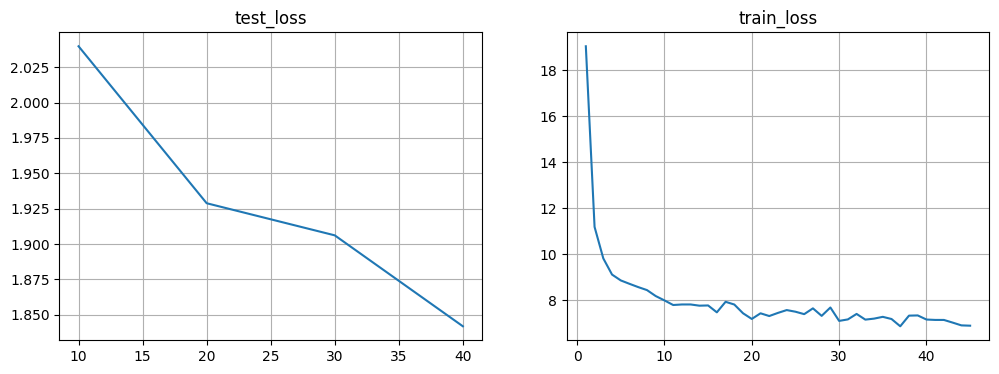

 29%|███████████████████████████████████▌                                                                                      | 14/48 [00:08<00:21,  1.56it/s, avg_epoch_loss=0.152, epoch=45]


KeyboardInterrupt: 

In [4]:
Train(csdi, train_loader, valid_loader)


In [3]:
state = torch.load(
    "../data/models/training/CSDIAdapter_20251202_130631/model.pth",
    map_location=device,
)

csdi.load_state_dict(state)
csdi.to(device)


CSDIAdapter(
  (csdi_model): CSDI_Forecasting(
    (embed_layer): Embedding(36, 16)
    (diffmodel): diff_CSDI(
      (diffusion_embedding): SinusoidalDiffusionEmbedding(
        (projection1): Linear(in_features=128, out_features=128, bias=True)
        (projection2): Linear(in_features=128, out_features=128, bias=True)
      )
      (input_projection): Conv1d(2, 64, kernel_size=(1,), stride=(1,))
      (output_projection1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (output_projection2): Conv1d(64, 1, kernel_size=(1,), stride=(1,))
      (residual_layers): ModuleList(
        (0-3): 4 x ResidualBlock(
          (diffusion_projection): Linear(in_features=128, out_features=64, bias=True)
          (cond_projection): Conv1d(145, 128, kernel_size=(1,), stride=(1,))
          (mid_projection): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
          (output_projection): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
          (time_layer): TransformerEncoder(
            (layers)

In [4]:
Evaluate(csdi, test_loader, normalization_stats)


  0%|                                                                                                                                                                   | 0/11 [00:00<?, ?it/s]

  0%|                                                                                                                                                                   | 0/11 [01:46<?, ?it/s]


UnboundLocalError: cannot access local variable 'scaler_tensor' where it is not associated with a value

In [ ]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import torch


def visualize_forecast_sample(
    evaluation_dir: str | Path,
    sample_index: int,
    feature_index: int,
    nsample: int = 10,
) -> None:
    """Plot observed values, the forecast median, and a prediction interval for a sample.

    Args:
        evaluation_dir: Directory produced by Evaluate containing `generated_outputs` files.
        sample_index: Index of the sample in the evaluation set to visualize.
        feature_index: Feature to visualize (0-indexed).
        nsample: Number of forecast samples used during evaluation.
    """
    evaluation_dir = Path(evaluation_dir)
    generated_path = evaluation_dir / f"generated_outputs_nsample{nsample}.pk"

    with open(generated_path, "rb") as f:
        (
            forecasted_data,
            forecast_mask,
            observed_data,
            observed_mask,
            time_points,
            scaler_tensor,
            mean_tensor,
        ) = pickle.load(f)

    forecasted_data = forecasted_data.cpu()
    forecast_mask = forecast_mask.cpu()
    observed_data = observed_data.cpu()
    observed_mask = observed_mask.cpu()
    time_points = time_points.cpu()
    scaler_tensor = scaler_tensor.cpu()
    mean_tensor = mean_tensor.cpu()

    forecast_samples = forecasted_data[sample_index, :, :, feature_index]
    sample_mask = forecast_mask[sample_index, :, feature_index].bool()
    observed_series = observed_data[sample_index, :, feature_index]
    observed_series_mask = observed_mask[sample_index, :, feature_index].bool()
    time_axis = time_points[sample_index, :, feature_index]

    mean = mean_tensor[feature_index]
    std = scaler_tensor[feature_index]

    observed_series = observed_series * std + mean
    forecast_samples = forecast_samples * std + mean

    median = forecast_samples.median(dim=0).values
    lower, upper = torch.quantile(
        forecast_samples, torch.tensor([0.1, 0.9], device=forecast_samples.device), dim=0
    )

    horizon_mask = ~sample_mask
    horizon_start = time_axis[horizon_mask][0] if horizon_mask.any() else None

    plt.figure(figsize=(10, 4))
    plt.scatter(
        time_axis[observed_series_mask],
        observed_series[observed_series_mask],
        label="Observed",
        color="black",
        s=10,
    )
    plt.plot(time_axis, median, label="Forecast median", color="tab:blue")
    plt.fill_between(
        time_axis, lower, upper, alpha=0.3, color="tab:blue", label="10-90% interval"
    )

    if horizon_start is not None:
        plt.axvspan(
            horizon_start, time_axis[-1], color="orange", alpha=0.1, label="Forecast horizon"
        )

    plt.xlabel("Time step")
    plt.ylabel("Value")
    plt.title("Forecast vs observed values")
    plt.legend()
    plt.tight_layout()


In [ ]:
visualize_forecast_sample("/path/to/evaluation_folder", sample_index=0, feature_index=0)
